In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpStatus, value


In [2]:
employees_df = pd.read_csv("employees.csv")
tickets_df = pd.read_csv("tickets.csv")

In [3]:
# Convert skills string to list
employees_df['Skills'] = employees_df['Skills'].str.split(',')

# Preview Data
print("Employees:")
print(employees_df)
print("\nTickets:")
print(tickets_df)

Employees:
  Employee                                          Skills
0    Alice                            [software, security]
1      Bob                 [printer, networking, hardware]
2  Charlie                                [wifi, database]
3    Diana                            [software, hardware]
4     Evan                    [printer, storage, software]
5    Fiona                    [storage, database, printer]
6   George  [wifi, security, software, database, hardware]
7   Hannah  [cloud, security, networking, hardware, email]
8      Ian                            [hardware, database]
9    Julia                                   [cloud, wifi]

Tickets:
   Ticket ID  Issue Type Priority  Response Time
0         T1        wifi     high             11
1         T2       email   medium             39
2         T3    database     high             19
3         T4        wifi      low             21
4         T5        wifi     high             12
5         T6    software   medium   

In [4]:
#Create Mapping of Valid Assignments
assignments = []
for ticket_index, ticket in tickets_df.iterrows():
    for emp_index, emp in employees_df.iterrows():
        if ticket['Issue Type'] in emp['Skills']:
            assignments.append((ticket_index, emp_index))

In [5]:
# Setup the Linear Programming Model
model = LpProblem("Ticket_Assignment_Optimization", LpMinimize)

# Decision Variables
x = LpVariable.dicts("assign", assignments, cat=LpBinary)

# Objective: Minimize total (priority-weighted) response time
priority_weights = {'high': 3, 'medium': 2, 'low': 1}
model += lpSum([
    x[(t, e)] * tickets_df.loc[t, 'Response Time'] * priority_weights[tickets_df.loc[t, 'Priority']]
    for (t, e) in assignments
])

In [6]:
#Constraints
# Each ticket must be assigned to one employee
for t in tickets_df.index:
    model += lpSum([x[(t, e)] for (tt, e) in assignments if tt == t]) == 1

# Employees only get matching skill tickets (already ensured via assignments)

# Balance workload: no employee gets more than ceil(avg), and each gets at least one ticket
avg_load = len(tickets_df) / len(employees_df)
max_load = int(avg_load + 1)
for e in employees_df.index:
    model += lpSum([x[(t, e)] for (t, ee) in assignments if ee == e]) <= max_load
    model += lpSum([x[(t, e)] for (t, ee) in assignments if ee == e]) >= 1  # avoid idle

In [7]:
# Solve the Model
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [8]:
# Extract Results
results = []
for (t, e) in assignments:
    if x[(t, e)].varValue == 1:
        results.append({
            'Ticket ID': tickets_df.loc[t, 'Ticket ID'],
            'Issue Type': tickets_df.loc[t, 'Issue Type'],
            'Assigned To': employees_df.loc[e, 'Employee'],
            'Response Time': tickets_df.loc[t, 'Response Time'],
            'Priority': tickets_df.loc[t, 'Priority']
        })
assignment_df = pd.DataFrame(results)
display(assignment_df)

,Ticket ID,Issue Type,Assigned To,Response Time,Priority
0,T1,wifi,George,11,high
1,T2,email,Hannah,39,medium
2,T3,database,Ian,19,high
3,T4,wifi,Charlie,21,low
4,T5,wifi,Charlie,12,high
5,T6,software,Diana,34,medium
6,T7,security,Alice,37,low
7,T8,printer,Fiona,22,low
8,T9,security,Hannah,36,medium
9,T10,cloud,Julia,21,high


C:\Users\pc\AppData\Local\Temp\ipykernel_21740\3946303993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=workload, x='Assigned To', y='Tickets Assigned', palette='viridis')


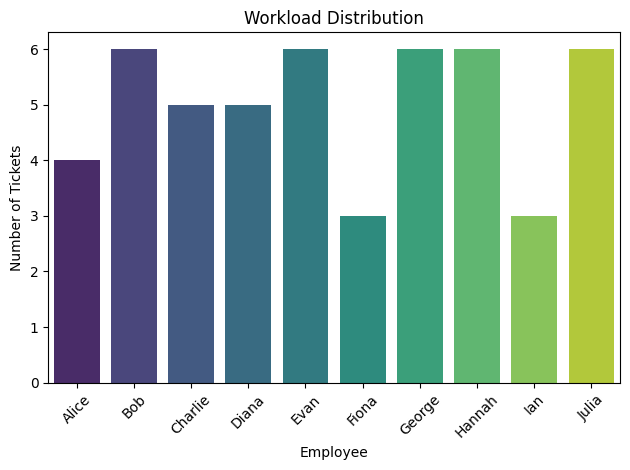

In [9]:
# Workload Distribution Visualization
workload = assignment_df.groupby('Assigned To').size().reset_index(name='Tickets Assigned')
sns.barplot(data=workload, x='Assigned To', y='Tickets Assigned', palette='viridis')
plt.title("Workload Distribution")
plt.ylabel("Number of Tickets")
plt.xlabel("Employee")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()